In [17]:
import pandas as pd
import numpy as np
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.utils import *
from sklearn.preprocessing import *


trainingSensor = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/1.Training/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Training_원천데이터/2_센서 데이터/1_자포니카/센서 측정값 데이터/sensor_val_tb.csv")
validationSensor = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/2.Validation/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Validation_원천데이터/2_센서 데이터/1_자포니카/센서 측정값 데이터/sensor_val_tb.csv")

trainingFood = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/1.Training/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Training_원천데이터/3_관리 데이터/1_자포니카/2_사료 공급관리 데이터/food_supply_tb.csv")
validationFood = pd.read_csv("E:/kimwoojae/AIGrowthModel/Eel/data/109.지능형 스마트양식장 이미지 데이터(뱀장어)/01.데이터/2.Validation/원천데이터/1-66_스마트양식장_이미지(뱀장어)_Validation_원천데이터/3_관리 데이터/1_자포니카/2_사료 공급관리 데이터/food_supply_tb.csv")

In [18]:
trainingSensor["mea_dt"] = trainingSensor["mea_dt"].apply(str)
trainingSensor["mea_dt"]  = trainingSensor["mea_dt"].str.slice(start=0, stop=15)
trainingFood['feed_dt'] = pd.to_datetime(trainingFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
trainingFood["feed_dt"]=trainingFood["feed_dt"].apply(str)
trainingFood["feed_dt"]  = trainingFood["feed_dt"].str.slice(start=0, stop=15)

validationSensor["mea_dt"] = validationSensor["mea_dt"].apply(str)
validationSensor["mea_dt"]  = validationSensor["mea_dt"].str.slice(start=0, stop=15)
validationFood['feed_dt'] = pd.to_datetime(validationFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
validationFood["feed_dt"] = validationFood["feed_dt"].apply(str)
validationFood["feed_dt"] = validationFood["feed_dt"].str.slice(start=0, stop=15)

In [19]:
training = pd.merge(left = trainingSensor, right = trainingFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation_oneday = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

In [20]:
training = training[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
validation = validation[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
training = training.fillna(0)
validation = validation.fillna(0)

In [21]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(training)
x_train_t = std_scaler.transform(training)
training = pd.DataFrame(x_train_t, columns=training.columns, index=list(training.index.values))

In [22]:
x_train = training[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_train = training[['do_mg']]
x_test = validation[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test = validation[['do_mg']]

In [23]:
x_train = np.asarray(x_train, dtype=np.float64)
x_test = np.asarray(x_test, dtype=np.float64)

In [24]:
x_train.shape

(1113748, 8)

In [25]:
x_train = x_train.reshape((-1, 1, 8))
x_test = x_test.reshape((-1, 1, 8))
x_train.shape

(1113748, 1, 8)

In [26]:
# shape확인
nCar = x_train.shape[0] # 데이터 개수
nVar = x_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_train.shape[0] # 데이터 개수
nVar = y_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = x_test.shape[0] # 데이터 개수
nVar = x_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1


In [27]:
from keras import backend as K
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [28]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, 8), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()
 
# 3. 실행
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            70144     
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 132,001
Trainable params: 132,001
Non-trainable params: 0
_________________________________________________________________


In [29]:
# hist = model.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_test, y_test))

In [30]:
# model.save('lstmJaponica4.h5')

In [31]:
from keras.models import load_model
model = load_model('lstmJaponica4.h5', custom_objects={'r_squared': r_squared})

In [42]:
pred = model.predict(x_test)

pred.shape
 

34805/34805 [==============================] - 51s 1ms/step


(1113748, 1)

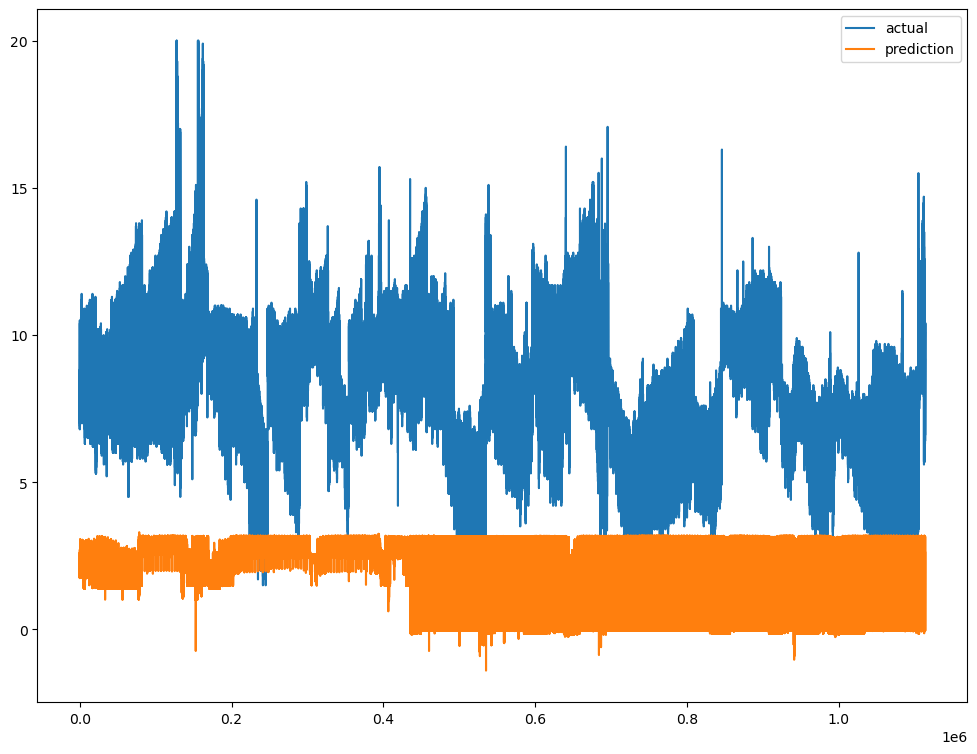

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()
 

[[-1.2664568  -1.4282112  -2.4017136  ...  2.067425    0.7731768
  -0.42515227]
 [-1.1070714  -0.8069595   1.2246329  ... -2.0592782   2.4291377
   0.2225754 ]
 [ 1.6419111  -2.4213028  -0.51305324 ... -0.9504021  -1.6035591
   1.1066236 ]
 ...
 [-0.60238993 -3.432236   -0.6919686  ... -0.23364532 -0.99720955
   0.426759  ]
 [ 1.0465183  -1.1800046  -1.1154777  ... -1.5251622  -0.33169958
  -1.8917707 ]
 [ 0.88341826 -1.1148164  -0.97365654 ... -1.4305133  -0.3959682
  -1.8975545 ]]


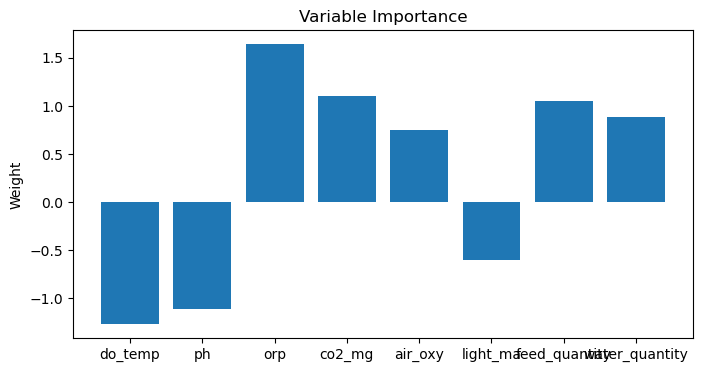

In [34]:
weights = model.layers[0].get_weights()[0]
print(weights)

import matplotlib.pyplot as plt

# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [35]:
from keras.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


# 평가
mse = model.evaluate(x_test, y_test)
mae = mean_absolute_error(y_test, pred)
r_squared = r2_score(y_test, pred)


print("MSE: ", mse)
print("MAE: ", mae)
print('R-squared:', r_squared)


34805/34805 [==============================] - 56s 2ms/step - loss: 39.6164 - mae: 5.8889 - r_squared: -96.1152
MSE:  [39.616424560546875, 5.888887882232666, -96.11518096923828]
MAE:  tf.Tensor([6.6571245 5.550832  5.5572643 ... 6.999518  8.645414  7.791568 ], shape=(1113748,), dtype=float32)
R-squared: -7.82760319180864


In [36]:
oneday = validation_oneday[(validation_oneday['mea_dt'].str.contains('2021-07-21'))&(validation_oneday['tank_id']==1)]
#oneday = validation_oneday[(validation.loc[:'2021-08-09 16:3'])&(validation['tank_id']==1)]
oneday = oneday.fillna(0)
x_test_oneday = oneday[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test_oneday = oneday[['do_mg']]

x_test_oneday = np.asarray(x_test_oneday, dtype=np.float64)
x_test_oneday = x_test_oneday.reshape((-1, 1, 8))

# shape확인
nCar = x_test_oneday.shape[0] # 데이터 개수
nVar = x_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_oneday.shape[0] # 데이터 개수
nVar = y_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


45/45 [==============================] - 0s 2ms/step


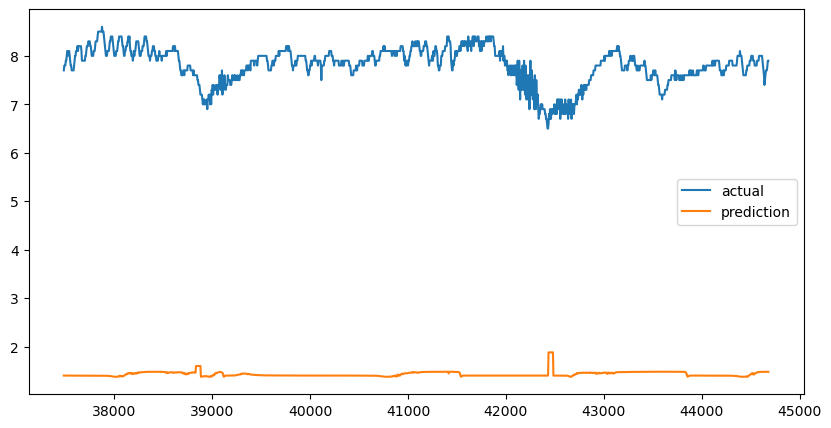

In [37]:
pred_oneday = model.predict(x_test_oneday)
plt.figure(figsize=(10, 5))
plt.plot(oneday.index, y_test_oneday, label = 'actual')
plt.plot(oneday.index, pred_oneday, label = 'prediction')
plt.legend()
plt.show()

In [44]:
std_scaler.fit(validation)
validation_t = std_scaler.transform(validation)
validation = pd.DataFrame(validation_t, columns=validation.columns, index=list(validation.index.values))

In [45]:
x_test = validation[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test = validation[['do_mg']]

In [46]:
x_test = np.asarray(x_test, dtype=np.float64)
x_test = x_test.reshape((-1, 1, 8))

In [47]:
# shape확인
nCar = x_test.shape[0] # 데이터 개수
nVar = x_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1


In [48]:
pred = model.predict(x_test)

pred.shape
 

34805/34805 [==============================] - 53s 2ms/step


(1113748, 1)

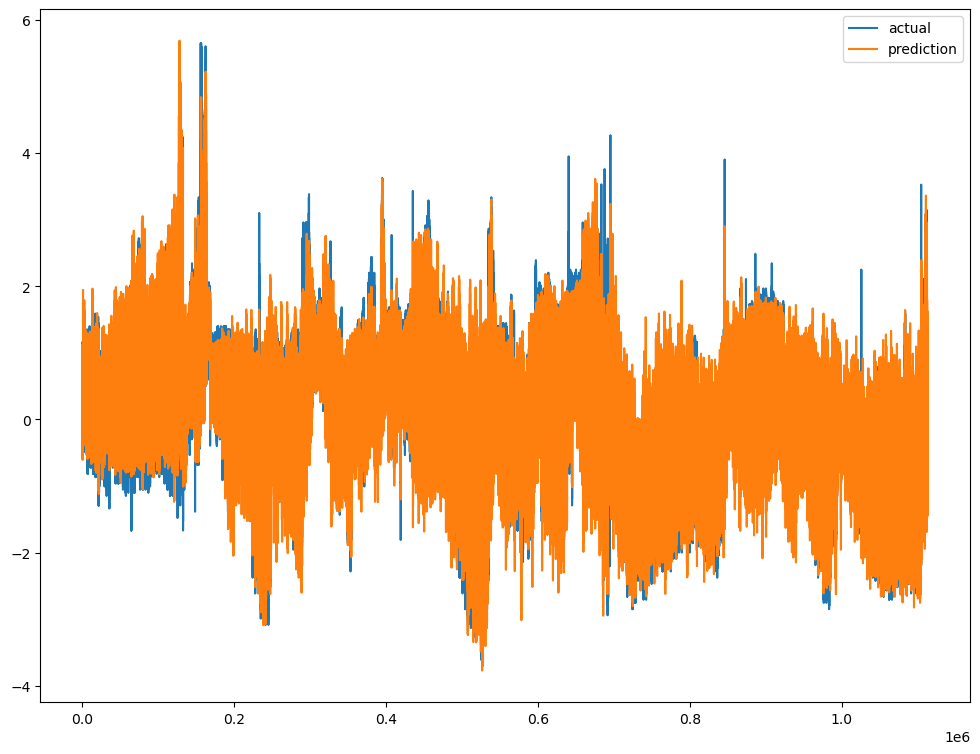

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()
 

[[-1.2664568  -1.4282112  -2.4017136  ...  2.067425    0.7731768
  -0.42515227]
 [-1.1070714  -0.8069595   1.2246329  ... -2.0592782   2.4291377
   0.2225754 ]
 [ 1.6419111  -2.4213028  -0.51305324 ... -0.9504021  -1.6035591
   1.1066236 ]
 ...
 [-0.60238993 -3.432236   -0.6919686  ... -0.23364532 -0.99720955
   0.426759  ]
 [ 1.0465183  -1.1800046  -1.1154777  ... -1.5251622  -0.33169958
  -1.8917707 ]
 [ 0.88341826 -1.1148164  -0.97365654 ... -1.4305133  -0.3959682
  -1.8975545 ]]


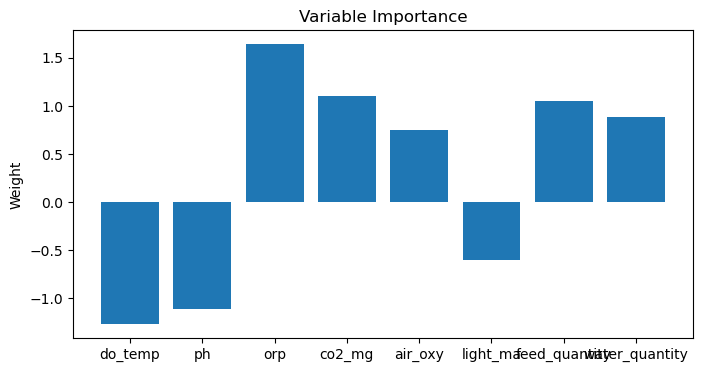

In [50]:
weights = model.layers[0].get_weights()[0]
print(weights)

import matplotlib.pyplot as plt

# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [51]:
from keras.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


# 평가
mse = model.evaluate(x_test, y_test)
mae = mean_absolute_error(y_test, pred)
r_squared = r2_score(y_test, pred)


print("MSE: ", mse)
print("MAE: ", mae)
print('R-squared:', r_squared)


34805/34805 [==============================] - 55s 2ms/step - loss: 0.1408 - mae: 0.2450 - r_squared: -0.0714
MSE:  [0.1408151537179947, 0.24497854709625244, -0.0713658258318901]
MAE:  tf.Tensor([0.16444209 0.02015987 0.02097273 ... 0.41896635 0.62633467 0.72109294], shape=(1113748,), dtype=float32)
R-squared: 0.8591846948120512


In [52]:
oneday = validation_oneday[(validation_oneday['mea_dt'].str.contains('2021-07-21'))&(validation_oneday['tank_id']==1)]
#oneday = validation_oneday[(validation.loc[:'2021-08-09 16:3'])&(validation['tank_id']==1)]
oneday = oneday.fillna(0)

oneday = oneday[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity', 'do_mg']]

std_scaler.fit(oneday)
oneday_t = std_scaler.transform(oneday)
oneday = pd.DataFrame(oneday_t, columns=oneday.columns, index=list(oneday.index.values))

x_test_oneday = oneday[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test_oneday = oneday[['do_mg']]

x_test_oneday = np.asarray(x_test_oneday, dtype=np.float64)
x_test_oneday = x_test_oneday.reshape((-1, 1, 8))

# shape확인
nCar = x_test_oneday.shape[0] # 데이터 개수
nVar = x_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_oneday.shape[0] # 데이터 개수
nVar = y_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


45/45 [==============================] - 0s 1ms/step


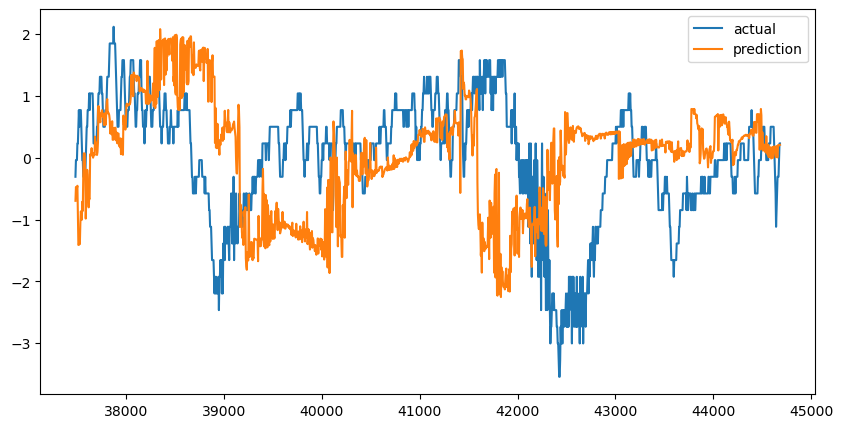

In [53]:
pred_oneday = model.predict(x_test_oneday)
plt.figure(figsize=(10, 5))
plt.plot(oneday.index, y_test_oneday, label = 'actual')
plt.plot(oneday.index, pred_oneday, label = 'prediction')
plt.legend()
plt.show()